In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "../code-previous")
sys.path.insert(0, "..")

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import sklearn.feature_extraction as skfeatures
import utils
import time
import os

import nltk
stopwords = nltk.corpus.stopwords.words('english')

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt
path2rawdata = '/mnt/disks/vault/wos2017-parsed/'

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
raw_data_path = "/mnt/disks/vault/analysis-data/raw_data_full/raw_data_full.pql"
data = pd.read_pickle(raw_data_path)

In [5]:
# New fields to dataframe 
data['log_c5'] = data['c5'].progress_apply(lambda x: np.log(x+1))
data['character_count'] = data['Title'].progress_apply(lambda x: len(x))
data["word_count"] = data["Title"].progress_apply(lambda x: len(x.split()))
data['title_without_punct'] = data['Title'].progress_apply(lambda x: 
                                                           str.lower(''.join(ch for ch in str(x) if category(ch)[0] != 'P')))
data["title_without_stopwords"] = data['title_without_punct'].progress_apply(lambda x: 
                                                                            " ".join([word for word in x.split() if word not in stopwords]))


data["word_count"] = data["Title"].progress_apply(lambda x: len(x.split()))
data["cleaned_title_word_count"] = data["title_without_stopwords"].progress_apply(lambda x: len(x.split()))

Progress: 100%|██████████| 738469/738469 [00:01<00:00, 590633.03it/s]


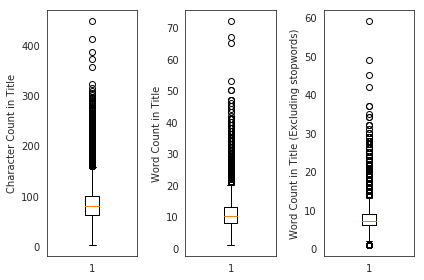

In [6]:
# What is the distribution of word counts in these papers 

# histogram of charcater/word distribution - with and without log scale

plt.subplot(1, 3, 1)
plt.boxplot(data['character_count'])
plt.ylabel("Character Count in Title")

plt.subplot(1, 3, 2)
plt.boxplot(data['word_count'])
plt.ylabel("Word Count in Title")

plt.subplot(1, 3, 3)
plt.boxplot(data['cleaned_title_word_count'])
plt.ylabel("Word Count in Title (Excluding stopwords)")

plt.tight_layout()

plt.show()

In [8]:
print(len(data))

data.head()

738469


,ArticleID,Type,Label,PubYear_x,Doctypes,Title,Journal,Journal Abbreviation ISO,PubYear_y,c5,log_c5,character_count,word_count,title_without_punct,title_without_stopwords,cleaned_title_word_count
0,A1981LJ96300019,ASCA traditional subject,"Physics, Applied",1981,Article,SURFACE COMPOSITIONAL MODIFICATIONS DURING O-2...,APPLIED PHYSICS LETTERS,Appl. Phys. Lett.,1981,6.0,1.945910,76,8,surface compositional modifications during o2+...,surface compositional modifications o2+ bombar...,6
1,A1981MM58300017,ASCA traditional subject,"Physics, Applied",1981,Article,ELECTRON-PHONON INTERACTION AND DEVIATIONS FRO...,JOURNAL OF PHYSICS F-METAL PHYSICS,,1981,0.0,0.000000,85,9,electronphonon interaction and deviations from...,electronphonon interaction deviations matthies...,6
2,A1981LV54600009,ASCA traditional subject,"Physics, Applied",1981,Article,EXPLOSIVE GENERATION OF ELECTROMAGNETIC-RADIAT...,ZHURNAL TEKHNICHESKOI FIZIKI,Zhurnal Tek. Fiz.,1981,0.0,0.000000,88,11,explosive generation of electromagneticradiati...,explosive generation electromagneticradiation ...,6
3,A1981LX06200023,ASCA traditional subject,"Physics, Applied",1981,Article,PIEZOELECTRIC ZNO TRANSDUCERS PRODUCED BY R.F....,THIN SOLID FILMS,Thin Solid Films,1981,7.0,2.079442,67,8,piezoelectric zno transducers produced by rf m...,piezoelectric zno transducers produced rf magn...,7
4,A1981LG93900006,ASCA traditional subject,"Physics, Applied",1981,Article,A MODEL FOR INHOMOGENEOUS CONDUCTION IN ANISOT...,JOURNAL OF PHYSICS F-METAL PHYSICS,,1981,3.0,1.386294,84,12,a model for inhomogeneous conduction in anisot...,model inhomogeneous conduction anisotropic mat...,7


In [9]:
# Examine the relationship of log_c5 to the number of words considering only one year
# For papers which was released in a year, what was the variation of log_c5 wrt to the number of words


# group the papers by year and number of words
data_grouped_wrt_year_word_count = data.groupby(['PubYear_x'], as_index=False)['c5'].mean()

# subtract every article's c5 from average c5 that year and divide by the average c5 for the year
data_grouped_wrt_year_word_count = data_grouped_wrt_year_word_count.rename(columns={"c5": "mean_c5_for_year"})

data = data.merge(data_grouped_wrt_year_word_count,
                  how = 'left',
                  on = 'PubYear_x')
data.head()

,ArticleID,Type,Label,PubYear_x,Doctypes,Title,Journal,Journal Abbreviation ISO,PubYear_y,c5,log_c5,character_count,word_count,title_without_punct,title_without_stopwords,cleaned_title_word_count,mean_c5_for_year
0,A1981LJ96300019,ASCA traditional subject,"Physics, Applied",1981,Article,SURFACE COMPOSITIONAL MODIFICATIONS DURING O-2...,APPLIED PHYSICS LETTERS,Appl. Phys. Lett.,1981,6.0,1.945910,76,8,surface compositional modifications during o2+...,surface compositional modifications o2+ bombar...,6,5.241389
1,A1981MM58300017,ASCA traditional subject,"Physics, Applied",1981,Article,ELECTRON-PHONON INTERACTION AND DEVIATIONS FRO...,JOURNAL OF PHYSICS F-METAL PHYSICS,,1981,0.0,0.000000,85,9,electronphonon interaction and deviations from...,electronphonon interaction deviations matthies...,6,5.241389
2,A1981LV54600009,ASCA traditional subject,"Physics, Applied",1981,Article,EXPLOSIVE GENERATION OF ELECTROMAGNETIC-RADIAT...,ZHURNAL TEKHNICHESKOI FIZIKI,Zhurnal Tek. Fiz.,1981,0.0,0.000000,88,11,explosive generation of electromagneticradiati...,explosive generation electromagneticradiation ...,6,5.241389
3,A1981LX06200023,ASCA traditional subject,"Physics, Applied",1981,Article,PIEZOELECTRIC ZNO TRANSDUCERS PRODUCED BY R.F....,THIN SOLID FILMS,Thin Solid Films,1981,7.0,2.079442,67,8,piezoelectric zno transducers produced by rf m...,piezoelectric zno transducers produced rf magn...,7,5.241389
4,A1981LG93900006,ASCA traditional subject,"Physics, Applied",1981,Article,A MODEL FOR INHOMOGENEOUS CONDUCTION IN ANISOT...,JOURNAL OF PHYSICS F-METAL PHYSICS,,1981,3.0,1.386294,84,12,a model for inhomogeneous conduction in anisot...,model inhomogeneous conduction anisotropic mat...,7,5.241389


In [10]:
def normalize_c5(row):
    return row['c5'] - row['mean_c5_for_year']

data['normalized_c5'] = data.progress_apply(normalize_c5, axis = 1)
data.head()

Progress: 100%|██████████| 738469/738469 [00:15<00:00, 46466.90it/s]


,ArticleID,Type,Label,PubYear_x,Doctypes,Title,Journal,Journal Abbreviation ISO,PubYear_y,c5,log_c5,character_count,word_count,title_without_punct,title_without_stopwords,cleaned_title_word_count,mean_c5_for_year,normalized_c5
0,A1981LJ96300019,ASCA traditional subject,"Physics, Applied",1981,Article,SURFACE COMPOSITIONAL MODIFICATIONS DURING O-2...,APPLIED PHYSICS LETTERS,Appl. Phys. Lett.,1981,6.0,1.945910,76,8,surface compositional modifications during o2+...,surface compositional modifications o2+ bombar...,6,5.241389,0.758611
1,A1981MM58300017,ASCA traditional subject,"Physics, Applied",1981,Article,ELECTRON-PHONON INTERACTION AND DEVIATIONS FRO...,JOURNAL OF PHYSICS F-METAL PHYSICS,,1981,0.0,0.000000,85,9,electronphonon interaction and deviations from...,electronphonon interaction deviations matthies...,6,5.241389,-5.241389
2,A1981LV54600009,ASCA traditional subject,"Physics, Applied",1981,Article,EXPLOSIVE GENERATION OF ELECTROMAGNETIC-RADIAT...,ZHURNAL TEKHNICHESKOI FIZIKI,Zhurnal Tek. Fiz.,1981,0.0,0.000000,88,11,explosive generation of electromagneticradiati...,explosive generation electromagneticradiation ...,6,5.241389,-5.241389
3,A1981LX06200023,ASCA traditional subject,"Physics, Applied",1981,Article,PIEZOELECTRIC ZNO TRANSDUCERS PRODUCED BY R.F....,THIN SOLID FILMS,Thin Solid Films,1981,7.0,2.079442,67,8,piezoelectric zno transducers produced by rf m...,piezoelectric zno transducers produced rf magn...,7,5.241389,1.758611
4,A1981LG93900006,ASCA traditional subject,"Physics, Applied",1981,Article,A MODEL FOR INHOMOGENEOUS CONDUCTION IN ANISOT...,JOURNAL OF PHYSICS F-METAL PHYSICS,,1981,3.0,1.386294,84,12,a model for inhomogeneous conduction in anisot...,model inhomogeneous conduction anisotropic mat...,7,5.241389,-2.241389


In [18]:
# mean of c5 score - grouped by year and word count

data_grouped_wrt_year_word_count = data.groupby(["PubYear_x", "word_count"], as_index=False)['normalized_c5'].mean()

data_grouped_wrt_year_word_count["avg_normalized_log_c5"] = data_grouped_wrt_year_word_count['normalized_c5'].progress_apply(lambda x: np.log(x+1))

data_grouped_wrt_year_word_count.head()

Progress: 100%|██████████| 2997/2997 [00:00<00:00, 332513.20it/s]


,PubYear_x,word_count,normalized_c5,avg_normalized_log_c5
0,1900,1,-0.235772,-0.268890
1,1900,2,-0.235772,-0.268890
2,1900,3,-0.235772,-0.268890
3,1900,4,-0.110772,-0.117402
4,1900,5,-0.135772,-0.145919


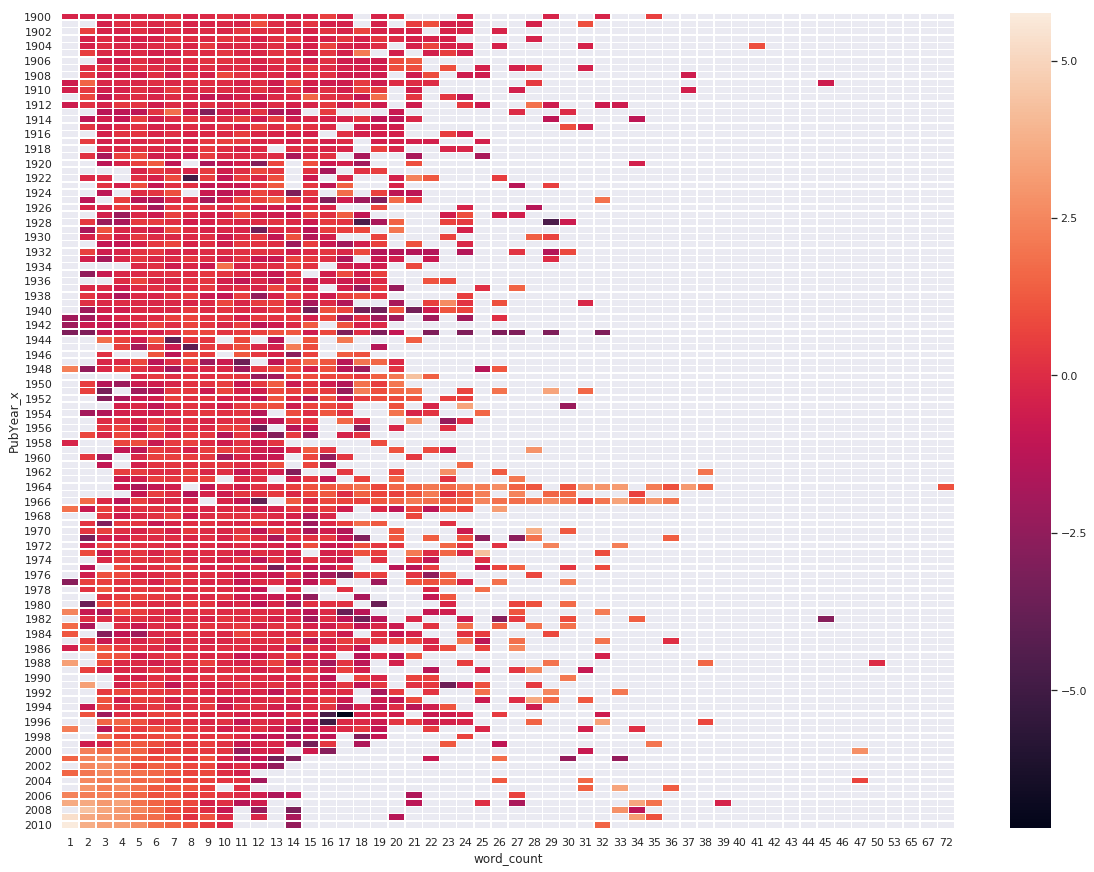

In [19]:
data_pivoted = data_grouped_wrt_year_word_count.pivot("PubYear_x", "word_count", "avg_normalized_log_c5")
sns.set(rc={'figure.figsize':(20,15)})
ax = sns.heatmap(data_pivoted, linewidths=.5)

plt.show()